# Access to the endpoint and data sources of CovidOnTheWeb dataset
### maintaned by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook is intended to help a user to begin quering the CovidOnTheWeb dataset. 

The full description of the dataset can be found here: https://github.com/Wimmics/CovidOnTheWeb

You can query the dataset from our Virtuoso endpoint: https://covidontheweb.inria.fr/sparql. 

The following named graphs can be queried from the SPARQL endpoint:

- `http://ns.inria.fr/covid19/graph/metadata`: dataset description + definition of a few properties
- `http://ns.inria.fr/covid19/graph/articles`: articles metadata (title, authors, DOIs, journal etc.)
- `http://ns.inria.fr/covid19/graph/dbpedia-spotlight`: named entities identified by DBpedia Spotlight in articles titles/abstracts
- `http://ns.inria.fr/covid19/graph/entityfishing`: named entities identified by Entity-fishing in articles titles/abstracts
- `http://ns.inria.fr/covid19/graph/entityfishing/body`: named entities identified by Entity-fishing in articles bodies
- `http://ns.inria.fr/covid19/graph/bioportal-annotator`: named entities identified by Bioportal Annotator in articles titles/abstracts
- `http://ns.inria.fr/covid19/graph/acta`: argumentative components and PICO elements extracted by ACTA from articles titles/abstracts


In [ ]:
from __future__ import print_function

## Install required packages

#### SPARQLWrapper 

This package helps to convert service output to a Pandas DataFrame. https://rdflib.dev/sparqlwrapper/

#### Pandas

Using Pandas DataFrame to contain the query results.


NOTE: if you are runing Anaconda distribution the prefered way to install packages:

_conda install -c conda-forge sparqlwrapper_

_conda install pandas_

Only run it once or periodically to check for the updates.

In [ ]:
!pip install pandas

In [ ]:
!pip install SPARQLWrapper

In [ ]:
import pandas as pd
print('Pandas ver.', pd.__version__)

import SPARQLWrapper
import json
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)

from SPARQLWrapper import SPARQLWrapper, JSON

In [ ]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)


# Run queries

In [ ]:
wds_Corese_Covid = 'https://covidontheweb.inria.fr/sparql'

### Simple query: select 10 articles with a reference to _coronavirus_

In [ ]:
query = '''
SELECT (group_concat(distinct ?name,", ") AS ?authors)
       ?title 
       (year(?date) as ?year)
       ?pub
       ?url
from <http://ns.inria.fr/covid19/graph/articles>
WHERE {
    ?doc a ?t;
        dce:creator ?name;
        dct:title ?title;
        schema:publication ?pub;
        schema:url ?url;
        dct:abstract [ rdf:value ?abs ].

    optional { ?doc dct:issued ?date }
    filter contains(?abs, "coronavirus")
} 
group by ?doc ?title ?date ?pub ?url
order by desc(?date)
limit 10

'''

In [66]:
%time df = sparql_service_to_dataframe(wds_Corese_Covid, query)
print(df.shape)

Wall time: 1.07 s
(10, 5)


Visualize results as a table

In [67]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('display.max_rows', 9999)

df.head()

,authors,title,year,pub,url
0,"Khan, Gulfaraz, Sheek-Hussein, Mohamud",Chapter 8 The Middle East Respiratory Syndrome Coronavirus: An Emerging Virus of Global Threat,2020,Emerging and Reemerging Viral Pathogens,https://doi.org/10.1016/b978-0-12-819400-3.00008-9
1,"Al, Hai, Bai, Chunxue, Bai, Li, Chen, Hong, Chen, Rongchang, Dong, Chunling, Han, Baohui, Jiang, Jinjun, Jiang, Yan, Jin, Yang, Li, Jing, Li, Qiang, Li, Shengqing, Liu, Jie, Ma, Xia, Powell, Charles, Qiu, Zhongmin, Shen, Yao, Shi, Guochao, Song, Yuanlin, Song, Zhenju, Sun, Jiayuan, Tan, Fei, Tapuyihai, Al, Tong, Lin, Tu, Chunlin, Wang, Changhui, Wang, Jiwei, Wang, Qi, Wang, Xiongbiao, Wang, Xun, Wang, Yaoli, Wang, Yuehong, Wu, Chaomin, Wu, Xueling, Xiao, Kui, Xu, Tao, Xu, Yu, Yang, Dawei, Ye, Maosong, Yu, Jinming, Yu, Wencheng, Zhang, Ding, Zhang, Lichuan, Zhang, Min, Zhang, Xiaoju, Zhang, Yong, Zhang, Ziqiang, Zhao, Lin, Zhong, Nanshan, Zhou, Jian, Zhou, Xin, Zhu, Huili, Zhu, Xiaodan",Chinese experts’ consensus on the Internet of Things-aided diagnosis and treatment of coronavirus disease 2019 (COVID-19),2020,Clinical eHealth,https://doi.org/10.1016/j.ceh.2020.03.001
2,"Compton, Susan, Macy, James",Chapter 13 Viral Disease,2020,The Laboratory Rat,https://doi.org/10.1016/b978-0-12-814338-4.00013-1
3,"Ennaji, Youssef, Khataby, Khadija, Mustapha, Moulay",Chapter 3 Infectious Bronchitis Virus in Poultry: Molecular Epidemiology and Factors Leading to the Emergence and Reemergence of Novel Strains of Infectious Bronchitis Virus,2020,Emerging and Reemerging Viral Pathogens,https://doi.org/10.1016/b978-0-12-814966-9.00003-2
4,"Kasmi, Yassine, Khataby, Khadija, Mustapha, Moulay, Souiri, Amal","Chapter 7 Coronaviridae: 100,000 Years of Emergence and Reemergence",2020,Emerging and Reemerging Viral Pathogens,https://doi.org/10.1016/b978-0-12-819400-3.00007-7


### Query Named Entities: select articles that co-mention _cancers_ and _coronaviruses_

In [ ]:
query_corona_vs_cancer = '''
prefix oa:     <http://www.w3.org/ns/oa#>
prefix schema: <http://schema.org/>
prefix rdfs:   <http://www.w3.org/2000/01/rdf-schema#>

prefix wd:     <http://www.wikidata.org/entity/>
prefix wdt:    <http://www.wikidata.org/prop/direct/>

# wdt:P279 = subclass of 
# wdt:P31 = instance of
# wd:Q12078 = cancer
# wd:Q1134583 = coronavirus family = Coronaviridae

select distinct ?article ?dis1 ?dis1Label ?dis2 ?dis2Label #?dis2Subject

from <http://ns.inria.fr/covid19/graph/entityfishing>
from named <http://ns.inria.fr/covid19/graph/wikidata-named-entities>

where {
    # Look for 2 annotations of the same article with Wikidata URIs ?dis1 and ?dis2 

    ?annot1 schema:about ?article; oa:hasBody ?dis1.
    ?annot2 schema:about ?article; oa:hasBody ?dis2.
 
    graph <http://ns.inria.fr/covid19/graph/wikidata-named-entities>
    {
      ?entity1 rdfs:label "cancer"@en. # ?entity1 is wd:Q12078
      
      { ?dis1 rdfs:label ?dis1Label.
        filter (?dis1 = ?entity1) } # ?dis1 is "cancer"

      UNION

      { ?dis1 wdt:P279 ?entity1;
              rdfs:label ?dis1Label. }  # ?dis1 is a subclass of "cancer" (at any depth)

      UNION

      { ?dis1 wdt:P31 ?entity1; 
              rdfs:label ?dis1Label. }  # ?dis1 is an instance of "cancer" or a subclass thereof



      ?entity2 rdfs:label "Coronaviridae"@en. # ?entity2 is wd:Q1134583

      { ?dis2 rdfs:label ?dis2Label. 
      filter (?dis2 = ?entity2) }

      UNION

      { ?dis2 wdt:P279 ?entity2;
              rdfs:label ?dis2Label. } # ?dis2 is a subclass of "Coronaviridae" (at any depth)

      UNION

      { ?dis2 wdt:P31 ?entity2; 
              rdfs:label ?dis2Label. }  # ?dis2 is an instance of "Coronaviridae" or a subclass thereof

    }

    
}
order by ?dis1 ?dis2
limit 1000
'''

In [68]:
%time df = sparql_service_to_dataframe(wds_Corese_Covid, query_corona_vs_cancer)
print(df.shape)

Wall time: 3.75 s
(153, 5)


Visualize results as a clustermap

Text(832.8749999999999, 0.5, 'cancers')

<Figure size 1296x288 with 0 Axes>

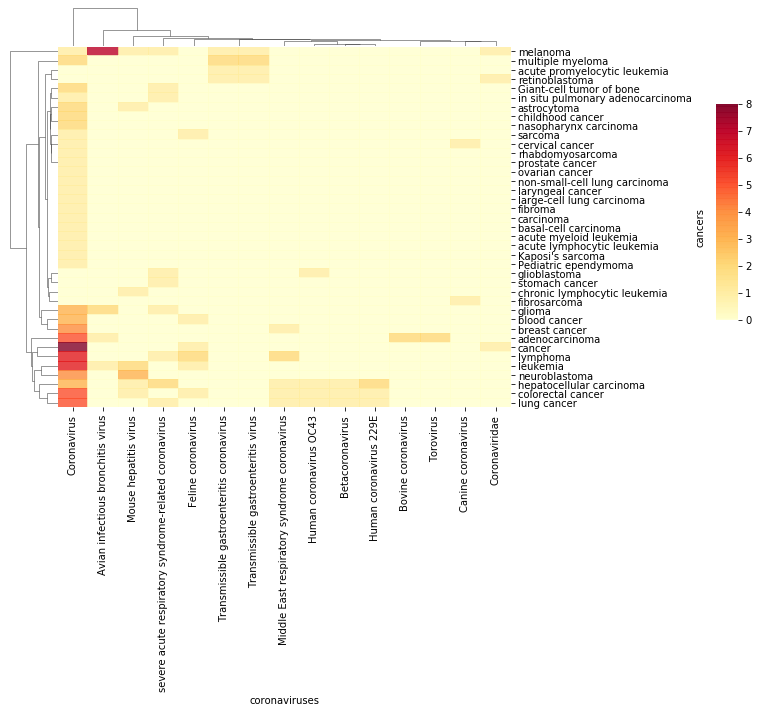

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.figure(figsize=(18, 4))
plt.suptitle('Co-mentions of cancer types and corona viruses in the articles.')

cooccurrence_matrix = pd.crosstab(df['dis1Label'], df['dis2Label'])

ax = sns.clustermap(cooccurrence_matrix, cmap='YlOrRd', alpha=0.8, dendrogram_ratio=(0.1, 0.1),
               cbar_pos=(1, .55, .03, .3))
ax.ax_heatmap.set_xlabel('coronaviruses')
ax.ax_heatmap.set_ylabel('cancers')